<a href="https://colab.research.google.com/github/rahuldave/LearningJax/blob/main/Jax_apps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jax applications

We finally showcase two applicattions using Jax.

Entire frameworks for deep learning have been created using Jax: flax or haiku, optax for optimization and much more. Jax is being used in MCMC inference engines; the easy gradients make for good Hamiltonian Monte Carlo implementations. People have written gradient boosting libraries in Jax..

Here we look at two relatively simple applications. The first is solving a differential equation using Jax, and the second is writing custom losses for Xgboost. Both are made possible by the automatic differentiation capabilities of Jax...

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [2]:
USE_TPU = False

if USE_TPU:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  # x8 cpu devices  
  import os
  os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

## Solving an ordinary differential equation

The code for this demo is taken from https://towardsdatascience.com/how-to-solve-an-ode-with-a-neural-network-917d11918932 .

Say we want to find the solution $y=f(x)$ to the differential equation:

$$y’=-2xy,$$

under some initial conditions, say  $y(0)=1$.

Remember that neural neyworks are big honking non-linear function approximators, so we ought to be able to come up with a scheme to solve differential equations approximately using them!

Lets say we use the following network as the approximation:

![](https://miro.medium.com/max/930/1*ABVRsdzou1-jjtUwH7qUKw.png)

It has 31 trainable parameters. We'll arange these parameters in another `pytree`, here an array.

In [3]:
import jax.numpy as jnp

def sigmoid(x):
    return 1./(1. + jnp.exp(-x))

def f(params, x):
    w0 = params[:10]
    b0 = params[10:20]
    w1 = params[20:30]
    b1 = params[30]
    y = sigmoid(x*w0 + b0)
    y = sigmoid(jnp.sum(y*w1) + b1)
    return y

Lets seed a random key and initialize these params using a standard normal distribution.

In [4]:
from jax import random

key = random.PRNGKey(0)
params = random.normal(key, shape=(31,))

Now we want to find $f'$ or $\frac{df}{dx}$ so we take the gradient with respect to the second argument:

In [7]:
from jax import grad

dfdx = grad(f, 1)

We need to find a range on which we need to solve the differential equation: these are the appropriate boundary conditions..

In [5]:
inputs = jnp.linspace(-2., 2., num=401)

Since Jax is being fed a sclar function to calculate the gradient, and we are not summing over the $x$ as we normally do in a loss calculation, we'll use out old friend `vmap` to vectorize out gradient over the input range...

In [8]:
from jax import vmap

f_vect = vmap(f, (None, 0))
dfdx_vect = vmap(dfdx, (None, 0))

The `(None, 0)` once agin maps to the arguments: map over the 0-axis of the second argument (x), while the first argument (params) is left untouched (or more precisely, with `None`, it will be broadcasted across the mapping).

All this is very nice, but how do we _enforce_ our differential equation? We do it the usual way, by defining a loss and minimizing it. Since our ODE is:

$$y’=-2xy,$$

we'll want:

$$y’ + 2xy$$

to be as small as possible. We'll also want $y(0)$ to be as close to 1 as possible. Putting in these two constraints into separate squared losses and adding them gives us:

In [9]:
from jax import jit

@jit
def loss(params, inputs):
    eq = dfdx_vect(params, inputs) + 2.*inputs*f_vect(params, inputs)
    ic = f(params, 0.) - 1.
    return jnp.mean(eq**2) + ic**2

Now everything is as before. Get the usual gradient of the loss with respect to the parameters and set up gradient descent. 

In [10]:
grad_loss = jit(grad(loss, 0))

We use Nesterov momentum for faster convergence..we dont need to but it illustrates how we might evaluate the jitted `grad_loss` function at slightly different parameter values.

![](https://miro.medium.com/max/740/1*KCRAjTK4244WKBZC6Zm8RQ.png)

In [11]:
epochs = 1000
learning_rate = 0.1
momentum = 0.99
velocity = 0.

for epoch in range(epochs):
    if epoch % 100 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params + momentum*velocity, inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity

epoch:   0 loss: 0.954726
epoch: 100 loss: 0.061131
epoch: 200 loss: 0.024128
epoch: 300 loss: 0.008868
epoch: 400 loss: 0.003202
epoch: 500 loss: 0.001567
epoch: 600 loss: 0.000880
epoch: 700 loss: 0.000505
epoch: 800 loss: 0.000306
epoch: 900 loss: 0.000224


How did we do? We plot our solution against the exact solution which is $exp(-x^2)$:

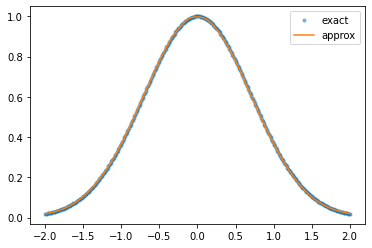

In [19]:
import matplotlib.pyplot as plt

plt.plot(inputs, jnp.exp(-inputs**2), '.', alpha=0.5,  label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()

## 2: Supplying xgboost a gradient and a Hessian

This demo is taken from https://towardsdatascience.com/jax-vs-pytorch-automatic-differentiation-for-xgboost-10222e1404ec which also shows how to do this using pytorch.

The basic idea of gradient boosting is the incremental learning of the residual from the previous weak learner..quite like a resnet. This residual can be described as a gradient in function space.

Any loss function can be minimized in gradient boosting, since there, the basic idea is to replace it by the mean squared error followed by a beam serach. You can think of this as roughly needing to model the gradient at any step by a week learner in the MSE sense, and thus we need both the gradient, and the gradient of the gradient, or the Hessian.

xhboost provides tons of loss functions, but also gives us the ability to write custom loss functions which we want to minimize. This is a usual trick in Kaggle competitions, and I have personally used it for losses like focal loss which are not defined in the package.

We'll use a custom loss function here, calles the Squared Log Error (SLE):

![](https://miro.medium.com/max/1400/0*sCTEDe1H7ee8gfX0.png)

As the article says:

>Note that this loss penalizes an under-predicted estimate greater than an over-predicted estimate. It could reflect a real business requirement when predicting house prices, and we are able to fulfill it by choosing a custom loss function.



In [20]:
import numpy as np
import pandas as pd
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
import jax
import jax.numpy as jnp
from tqdm.notebook import tqdm
import plotly.express as px
from functools import partial
from typing import Callable

We use `grad` to calculate the gradient of the SLE loss, and then use `hvp` provided by jax to calculate the Hessian. As the article says:

>Note that we use the hvp (Hessian-vector product) function (on a vector of ones) from [JAX’s Autodiff Cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#hessian-vector-products-using-both-forward-and-reverse-mode) to calculate the diagonal of the Hessian. This trick is possible only when the Hessian is diagonal (all non-diagonal entries are zero), which holds in our case. This way, we never store the entire hessian, and calculate it on the fly, reducing memory consumption.

In [21]:
def jax_sle_loss(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate the Squared Log Error loss."""
    return (1/2 * (jnp.log1p(y_pred) - jnp.log1p(y_true))**2)

def hvp(f, inputs, vectors):
    """Hessian-vector product."""
    return jax.jvp(jax.grad(f), inputs, vectors)[1]

def jax_autodiff_grad_hess(
    loss_function: Callable[[np.ndarray, np.ndarray], np.ndarray],
    y_true: np.ndarray, y_pred: np.ndarray
):
    """Perform automatic differentiation to get the
    Gradient and the Hessian of `loss_function`."""
    loss_function_sum = lambda y_pred: loss_function(y_true, y_pred).sum()

    grad_fn = jax.grad(loss_function_sum)
    grad = grad_fn(y_pred)

    hess = hvp(loss_function_sum, (y_pred,), (jnp.ones_like(y_pred), ))

    return grad, hess

We create our training data...

In [22]:
X, y = sklearn.datasets.fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.05, random_state=0)
print(f"Train Data: {X_train.shape[0]} examples, {X_train.shape[1]} features")

Train Data: 1032 examples, 8 features


We `jit` the function returning both the loss and the hessian after it has been curried with the input loss function using python's `partial`. This is needed because we need to both `grad` and `hvp` this loss, but the xgboost specification only wants us to provide `y_true` and `y_pred` as inputs. (you saw an example of this "closure" strategy earlier when we were talking about functional programming.

Then we fit for 100 epochs or 100 trees and do are regular gradient boosting stuff..

In [23]:
jax_objective = jax.jit(partial(jax_autodiff_grad_hess, jax_sle_loss))
reg = XGBRegressor(objective=jax_objective, n_estimators=100)
reg.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose=True)

[13:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.89628
[1]	validation_0-rmse:1.84526
[2]	validation_0-rmse:1.79421
[3]	validation_0-rmse:1.74338
[4]	validation_0-rmse:1.69278
[5]	validation_0-rmse:1.64275
[6]	validation_0-rmse:1.59351
[7]	validation_0-rmse:1.54489
[8]	validation_0-rmse:1.49703
[9]	validation_0-rmse:1.45083
[10]	validation_0-rmse:1.4057
[11]	validation_0-rmse:1.36191
[12]	validation_0-rmse:1.3194
[13]	validation_0-rmse:1.27866
[14]	validation_0-rmse:1.23975
[15]	validation_0-rmse:1.20226
[16]	validation_0-rmse:1.16705
[17]	validation_0-rmse:1.13363
[18]	validation_0-rmse:1.1021
[19]	validation_0-rmse:1.0719
[20]	validation_0-rmse:1.04363
[21]	validation_0-rmse:1.01775
[22]	validation_0-rmse:0.993397
[23]	validation_0-rmse:0.970323
[24]	validation_0-rmse:0.948407
[25]	validation_0-rmse:0.929901
[26]	validation_0-rmse:0.910937
[27]	validation_0-rmse:0.894408
[28]	validati

XGBRegressor(objective=<CompiledFunction of functools.partial(<function jax_autodiff_grad_hess at 0x7fbe8ef99170>, <function jax_sle_loss at 0x7fbe8ef48440>)>)